In [118]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("Current Device Index:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
GPU Count: 1
Current Device Index: 0
GPU Name: NVIDIA A100 80GB PCIe


In [49]:
import xmltodict, json
import os
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import json, re

# Load Raw Dataset

In [50]:
# Change to path to the data
# path = '/home/wt/Downloads/n2c2 2012/'
# wp = '/home/jovyan/work/Temporal_relation/'
wp = "./"
path = wp + 'data/i2b2/'
training_data_path = path + 'original_training'
test_data_path = path + 'ground_truth/unmerged_xml'

In [51]:
def data_loader(data_path):
    """data: {
        filename: {
            "ClinicalNarrativeTemporalAnnotation":{
                "TEXT": text,
                "TAGS": {
                    'EVENT': list({
                        'id':id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'modality': whether an EVENT actually occurred or not ('FACTUAL','CONDITIONAL','POSSIBLE','PROPOSED') 
                        'polarity': positive or negative ('POS'/'NEG'), 
                        'type': event type ('TEST','PROBLEM','TREATMENT','CLINICAL_DEPT','EVIDENTIAL','OCCURENCE')
                        }),
                    'TIMEX3':list({
                        'id':id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'type': event type ('DATE','TIME','DURATION','FREQUENCY'),
                        'val': regularised time expression,
                        'mod': modifier for regularised time expression,
                        }),
                    'TLINK':list({
                        'id':id, 
                        'fromID': head event/timex3 id, 
                        'fromText': head event/timex3 text, 
                        'toID': tail event/timex3 id, 
                        'toText': tail event/timex3 text,
                        'type': temporal relation type ('BEFORE', 'AFTER', 'OVERLAP'),
                        }),
                    'SECTIME': list({
                        'id': id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'type': 'ADMISSION'/'DISCHARGE',
                        'dvalue': regularised date time,
                        }),
                }
            }
        }
    }
    """
    data = {}
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"): 
            f = (os.path.join(data_path, filename))
#             print(f)
            fb = open(f, "rb").read().decode(encoding="utf-8")
#     invalid character '&' https://github.com/martinblech/xmltodict/issues/277
            fb = fb.replace('&', '&amp;')
            dic = xmltodict.parse(fb, attr_prefix='')
#     restore orginal character "&"
            dic['ClinicalNarrativeTemporalAnnotation']['TEXT'] = dic['ClinicalNarrativeTemporalAnnotation']['TEXT'].replace('&amp;', '&')
            data[filename] = (dic)
    return data

In [52]:
train_data = data_loader(training_data_path)
test_data = data_loader(test_data_path)

In [54]:
print(len(train_data), len(test_data))

190 120


In [55]:
def find_first_regex(text, substrings):
    pattern = '|'.join(map(re.escape, substrings))  # Escape special characters
    match = re.search(pattern, text)
    if match:
        return match.start()
    else:
        raise ValueError("None of the substrings found in the text.")

In [56]:

def build_section_graph(doc_id, data):
    """构建完整的图，不做任何过滤，并补全边的对称关系。
    注：根据时序关系对某些边进行了反向处理，同时对于SIMULTANEOUS，OVERLAP进行了双向处理；
    具体操作的时候，先对所有边构建了反向边；然后删掉了不想要的逆时序边；
    """
    
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']

    # 读取事件信息
    events = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['EVENT'])
    events['start'] = events['start'].astype(int)
    events['end'] = events['end'].astype(int)

    # 读取时间信息
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    times['start'] = times['start'].astype(int)
    times['end'] = times['end'].astype(int)

    # 获取所有需要保留的节点
    nodes_keep = list(events['id']) + list(times['id'])

    # 读取时间关系（TLINK）
    all_links = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TLINK'])
    all_links = all_links.loc[all_links['type'] != '']  # 只保留有意义的边

    # 构建有向图，添加原始变
    G = nx.from_pandas_edgelist(all_links[['fromID', 'toID', 'type']], source='fromID', target='toID', edge_attr=True, create_using=nx.DiGraph())
    
    # 添加事件和时间节点
    events = events.assign(event_or_time="event")
    times = times.assign(event_or_time="time")

    # 设置节点属性
    nx.set_node_attributes(G, events.set_index("id").to_dict(orient="index"))
    nx.set_node_attributes(G, times.set_index("id").to_dict(orient="index"))

    # 定义对称关系映射
    reciprocal_relations = {
        'BEFORE': 'AFTER',
        'AFTER': 'BEFORE',
        'SIMULTANEOUS': 'SIMULTANEOUS',
        'OVERLAP': 'OVERLAP',
        'BEGUN_BY': 'BEGINS',
        'BEGINS': 'BEGUN_BY',
        'ENDED_BY': 'ENDS',
        'ENDS': 'ENDED_BY',
        'DURING': 'COVER',
        'COVER': 'DURING',
        'BEFORE_OVERLAP': 'AFTER_OVERLAP',
        'AFTER_OVERLAP': 'BEFORE_OVERLAP'
    }

    # 遍历所有边，补全对称关系
    edges_to_add = []
    for u, v, data in G.edges(data=True):
        type_u_v = data.get('type', '').upper()  # 规范化大小写
        if u not in G[v]:  # 检查是否已经存在 v → u
            reciprocal_type = reciprocal_relations.get(type_u_v, None)
            if reciprocal_type:
                edges_to_add.append((v, u, reciprocal_type))
    # 添加补全的边
    for v, u, relation in edges_to_add:
        G.add_edge(v, u, type=relation)

    # 过滤逆时序边
    edge_types_to_remove = {'AFTER', 'BEGUN_BY', 'ENDS', 'DURING', 'AFTER_OVERLAP'}
    # 过滤出要删除的边
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') in edge_types_to_remove]
    # 删除边
    G.remove_edges_from(edges_to_remove)


    # 只保留 nodes_keep 里的节点
    G = G.subgraph(nodes_keep).copy()

    return G, text


In [57]:
G, text = build_section_graph('36.xml', train_data)

# Analysis Tools

In [58]:
def draw_graph(G, center_node=None, show_edge_labels=False):
    """
    center_node: 把指定节点放在中心；
    show_edge_labels: 是否标出边类型
    """
    # 获取节点类型
    time_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["date", "time"]]
    time_attr_nodes =  [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["frequency", "duration"]]
    event_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["test", "problem", "treatment"]]
    occur_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["occurrence"]]
    event_attr_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["evidential", "clinical_dept"]]

    # 选择合适的布局
    if center_node and center_node in G: # 没找到好算法，还是比较丑
        # 以 center_node 为核心，其他节点围绕它
        # pos = nx.shell_layout(G, [ [center_node], list(set(G.nodes) - {center_node}) ])
        pos = nx.kamada_kawai_layout(G)
        # **固定 `center_node` 在中间**
        pos[center_node] = [0, 0]  # 将 center 放到中心
        # 重新调整 center附近的节点，使它们稍微分散
        for node in G.neighbors(center_node): 
            if node in pos:
                pos[node][0] += 0.5  # 轻微横向移动
    else:
        # 更均匀的布局
        pos = nx.kamada_kawai_layout(G)

    # 绘制图
    plt.figure(figsize=(20, 10))

    # 绘制 edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="gray")

    # 绘制 event 节点（用蓝色）
    nx.draw_networkx_nodes(G, pos, nodelist=event_nodes, node_color="blue", node_size=40, label="Event Nodes")
    nx.draw_networkx_nodes(G, pos, nodelist=occur_nodes, node_color="green", node_size=40, label="Occurrence Nodes")
    nx.draw_networkx_nodes(G, pos, nodelist=event_attr_nodes, node_color="lightblue", node_size=40, label="Event Attr Nodes")

    # 绘制 time 节点 
    nx.draw_networkx_nodes(G, pos, nodelist=time_nodes, node_color="red", node_size=40, label="Time Nodes") 
    nx.draw_networkx_nodes(G, pos, nodelist=time_attr_nodes, node_color="pink", node_size=40, label="Time Attr Nodes")

    # 绘制 labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

    # **绘制边的类型**
    if show_edge_labels:
        edge_labels = {(u, v): G[u][v].get("type", "") for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="gray")

    # 显示图例
    plt.legend()
    plt.title("Graph")
    plt.show()

In [59]:
def print_node_connected_nodes(G, node):
    """
    打印连接到一个节点的邻居信息
    """
    attrs = G.nodes[node]
    print(f"Node: {node}, Type: {attrs['type']}, Text:{attrs['text']}")
    # 获取所有出边（node → neighbor）
    for neighbor in G.successors(node):  # 仅获取出边
        neighbor_type = G.nodes[neighbor].get("type", "Unknown")  # 获取邻居的类型
        neighbor_text = G.nodes[neighbor].get("text", "Unknown")
        edge_type = G.edges[node, neighbor].get("type", "Unknown")  # 获取边的类型
        print(f"    后继节点: {neighbor}, 类型: {neighbor_type}, 文本: {neighbor_text}, 关系: {edge_type}")

    # 获取所有入边（neighbor → node）
    for neighbor in G.predecessors(node):  # 仅获取入边
        neighbor_type = G.nodes[neighbor].get("type", "Unknown")  # 获取邻居的类型
        neighbor_text = G.nodes[neighbor].get("text", "Unknown")
        edge_type = G.edges[neighbor, node].get("type", "Unknown")  # 获取边的类型
        print(f"    前序节点: {neighbor}, 类型: {neighbor_type},  文本: {neighbor_text}, 关系: {edge_type}")

In [60]:
def print_paths(G, paths, abbr_path=True):
    """
    打印路径
    """
    for path in paths:
        formatted_path = []
        for i in range(len(path) - 1):
            n1, n2 = path[i], path[i + 1]
            n1_info = G.nodes[n1]
            n2_info = G.nodes[n2]
            relation = G.get_edge_data(n1, n2).get("type", "UNKNOWN")
            
            if abbr_path:
                formatted_path.append(f"{n1}")
            else:
                formatted_path.append(f"({n1}, {n1_info['type']}, {n1_info.get('text', '')})")
            
            formatted_path.append(f" -> [{relation}] -> ")
        
        last_node = G.nodes[path[-1]]
        if abbr_path:
            formatted_path.append(f"{path[-1]}")
        else:
            formatted_path.append(f"({path[-1]}, {last_node['type']}, {last_node.get('text', '')})")
        
        print("".join(formatted_path))

# Task 1: Start Time Inference
## - 数据构建：
1. 找到每个事件到Time or Date的路径
2. 根据逻辑推理事件的起始时间，或起始时间区间

In [87]:
def get_paths_to_time_nodes(G, node, filter_overlap=False, filter_mult_time_paths=False, filter_consecutive_durations=False):
    """
    获取从 `node` 到所有 `time` 节点以及从 `time` 节点到 `node` 的路径。
    """
    if node not in G:
        return []
    
    time_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type").lower() in ["time", "date"]]

    def path_contains_excluded_edge(path):
        for u, v in zip(path[:-1], path[1:]):
            edge_type = G.get_edge_data(u, v, {}).get('type', 'UNKNOWN')
            if filter_overlap and edge_type in ["OVERLAP", "UNKNOWN"]:
                return True
        return False

    def path_contains_multiple_time_nodes(path):
        time_node_count = sum(1 for n in path if n in time_nodes)
        return time_node_count > 1
    
    def path_contains_consecutive_durations(path):
        for i in range(len(path) - 1):
            if G.nodes[path[i]].get("type", "").lower() == "duration" and \
               G.nodes[path[i + 1]].get("type", "").lower() == "duration":
                return True
        return False

    def find_paths(source, target):
        paths = []
        for path in nx.all_simple_paths(G, source=source, target=target):
            if filter_overlap and path_contains_excluded_edge(path):
                continue
            if filter_mult_time_paths and path_contains_multiple_time_nodes(path):
                continue
            if filter_consecutive_durations and path_contains_consecutive_durations(path):
                continue
            paths.append(path)
        return paths
    
    in_paths = []
    out_paths = []
    for time_node in time_nodes:
        out_paths += find_paths(source=node, target=time_node)
        in_paths += find_paths(source=time_node, target=node)
    
    return in_paths, out_paths

In [126]:
from datetime import datetime 
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

def parse_duration(duration_str):
    """
    解析 duration 字符串格式 P[n][Y/M/W/D]，转换成 datetime timedelta 或 relativedelta。
    :param duration_str: str, 格式如 'P2Y', 'P3M', 'P1W', 'P5D'
    :return: relativedelta 或 timedelta 对象
    """
    duration_str = duration_str.lower()
    if duration_str.startswith("pt"):
        unit = duration_str[-1]
        str_splits = duration_str[2:-1].split('.')[:1]
        if len(str_splits) == 2:
            v_i = int(str_splits[0])
            v_d = float(f"0.{str_splits[1]}")
        else:
            v_i = int(str_splits[0])
            v_d = 0
        if unit == "h":
            return relativedelta(hours=v_i, minutes=round(60*v_d))
        elif unit == "m":
            return relativedelta(minutes=v_i, seconds=round(60*v_d))
        elif unit == "s":
            return relativedelta(seconds=round(v_i + v_d))
        else:
            print("Invalid duration unit:%s. Must be PT[n][H/M/S] or P[n][Y/M/W/D]."%duration_str)
            return None

    elif duration_str.startswith("p"):
        unit = duration_str[-1]
        str_splits = duration_str[1:-1].split('.')[:1]
        if len(str_splits) == 2:
            v_i = int(str_splits[0])
            v_d = float(f"0.{str_splits[1]}")
        else:
            v_i = int(str_splits[0])
            v_d = 0
        if unit == "y":
            return relativedelta(years=v_i, months=round(12*v_d))
        elif unit == "m":
            return relativedelta(months=v_i, days=round(30*v_d))
        elif unit == "w":
            return relativedelta(weeks=v_i, days=round(7*v_d))
        elif unit == "d":
            return relativedelta(days=v_i, hours=round(24*v_d))
        else:
            print("Invalid duration unit:%s. Must be PT[n][H/M/S] or P[n][Y/M/W/D]."%duration_str)
            return None
    else:
        print("Invalid duration format. Must start with 'P'.")
        return None
    
def intersect_time_intervals(intervals):
    """
    计算一系列时间区间的交集。
    :param intervals: List of  [['at/before/after', time_val, time_str], ...]
    :return: (start_time, end_time) 交集区间 或 None（若无交集）
    """
    if not intervals:
        return (datetime.min, datetime.max, "NO INFO")
    
    starts = [parse(x[1]) if x[0] in ['at','after'] else datetime.min for x in intervals]
    ends = [parse(x[1]) if x[0] in ['at','before'] else datetime.max for x in intervals]
    start_index, start_value = max(enumerate(starts), key=lambda x: x[1])
    start_text = intervals[start_index][2]
    end_index, end_value = min(enumerate(ends), key=lambda x: x[1])
    end_text = intervals[end_index][2]

    if start_value <= end_value:
        if start_value == end_value:
            text = 'AT %s'%start_text
        elif start_value == datetime.min:
            text = 'BEFORE %s'%end_text
        elif end_value == datetime.max:
            text = 'AFTER %s'%start_text
        else:
            text = "%s TO %s"%(start_text, end_text)
        return (start_value, end_value, text)
    else:
        return None    

def infer_head_start_time(G, out_paths):
    """
    currentnode -> timenode
    根据 out_paths 逻辑推断 head 的开始时间，返回一个一致且最精确的起始时间区间。
    """
    inferred_times = []
   
    def process_duration_node(node, inferred_time, link_type):
        """特殊逻辑处理 duration 节点的开始时间"""
        duration_text = G.nodes[node].get("text")
        duration = parse_duration(G.nodes[node].get("val"))
        
        if link_type == "BEFORE" or link_type == "BEFORE_OVERLAP":
            if inferred_time[0] == 'after': inferred_time = None
            if inferred_time:
                inferred_time[0] == 'before'
                new_time = parse(inferred_time[1]) - duration
                inferred_time[1] = new_time.strftime("%Y-%m-%dT%H:%M:%S")
                inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        elif link_type == "SIMULTANEOUS":
            pass # unchanged
        elif link_type == "BEGINS":
            pass # unchanged
        elif link_type == "ENDED_BY":
            if inferred_time[0] == 'after': # before和at的情况不变
                inferred_time = None
            else:
                new_time = parse(inferred_time[1]) - duration
                inferred_time[1] = new_time.strftime("%Y-%m-%dT%H:%M:%S")
                inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        elif link_type == "COVER":
            if inferred_time[0] == 'after': inferred_time = None
            else:
                inferred_time[0] == 'before' 
        elif link_type == "OVERLAP":
            pass # 对duration的overlap事件放宽为和simultaneous一样处理
        else:
            inferred_time = None
            print("Warning: unknown relation type %s"%link_type)

        # if duration and inferred_time:
        #     new_time = parse(inferred_time[1]) - duration
        #     inferred_time[1] = new_time.strftime("%Y-%m-%dT%H:%M:%S")
        #     inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        # else:
        #     return None

        return inferred_time

    for path in out_paths:
        time_node = path[-1]
        time_attrs = G.nodes[time_node]
        inferred_time = ['at', time_attrs['val'], time_attrs['text']]
        
        for i in range(len(path) - 2, -1, -1):  # 逆向遍历路径
            node = path[i]
            node_type = G.nodes[node].get("type", "").upper()
            link_type = G.get_edge_data(path[i], path[i + 1], {}).get("type", "").upper()
            if not node_type or not link_type:
                inferred_time = None
                break
            if node_type == 'DURATION':
                inferred_time = process_duration_node(node, inferred_time, link_type)
            else:
                if link_type == "BEFORE":
                    if inferred_time[0] != 'after': 
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "BEFORE_OVERLAP":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "SIMULTANEOUS":
                    pass # unchanged
                elif link_type == "BEGINS":
                    pass # unchanged
                elif link_type == "ENDED_BY":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before'
                    else:
                        inferred_time = None
                elif link_type == "COVER":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "OVERLAP":
                    inferred_time = None
                else:
                    inferred_time = None
                    print("Warning: unknown relation type %s"%link_type)
            if not inferred_time:
                break  
        
        if inferred_time:
            inferred_times.append(inferred_time)

    # print(inferred_times)
    # start_time = intersect_time_intervals(inferred_times)
    return inferred_times
                        

def infer_tail_start_time(G, out_paths):
    """
    timenode -> currentnode
    根据 out_paths 逻辑推断 tail 的开始时间，返回一个一致且最精确的起始时间区间。
    """
    inferred_times = []
   
    def process_duration_node(node, inferred_time, link_type):
        """特殊逻辑处理 duration 节点的开始时间"""
        duration_text = G.nodes[node].get("text")
        duration = parse_duration(G.nodes[node].get("val"))
        
        if link_type == "BEFORE" or link_type == "BEFORE_OVERLAP":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
            else:
                inferred_time = None
        elif link_type == "SIMULTANEOUS":
            pass # unchanged
        elif link_type == "BEGINS":
            pass # unchanged
        elif link_type == "ENDED_BY":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
            else:
                inferred_time = None
        elif link_type == "COVER":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
            else:
                inferred_time = None
        elif link_type == "OVERLAP":
            pass # 对duration的overlap事件放宽为和simultaneous一样处理
        else:
            inferred_time = None
            print("Warning: unknown relation type %s"%link_type)

        if duration and inferred_time:
            inferred_time # 在向后路径上，duration时长不能推断开始时间
        else:
            return None

        

    for path in out_paths:
        time_node = path[0]
        time_attrs = G.nodes[time_node]
        inferred_time = ['at', time_attrs['val'], time_attrs['text']]
        
        for i in range(1, len(path), 1):  
            node = path[i]
            node_type = G.nodes[node].get("type", "").upper()
            link_type = G.get_edge_data(path[i-1], path[i], {}).get("type", "").upper()
            if not node_type or not link_type:
                inferred_time = None
                break
            if node_type == 'DURATION':
                inferred_time = process_duration_node(node, inferred_time, link_type)
            else:
                if link_type == "BEFORE":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "BEFORE_OVERLAP":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "SIMULTANEOUS":
                    pass # unchanged
                elif link_type == "BEGINS":
                    pass # unchanged
                elif link_type == "ENDED_BY":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "COVER":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "OVERLAP":
                    inferred_time = None
                else:
                    inferred_time = None
                    print("Warning: unknown relation type %s"%link_type)
            if not inferred_time:
                break  
        
        if inferred_time:
            inferred_times.append(inferred_time)

    # print(inferred_times)
    # start_time = intersect_time_intervals(inferred_times)
    return inferred_times            


In [127]:
in_paths, out_paths = get_paths_to_time_nodes(G, 'T2', filter_overlap=True, filter_mult_time_paths=True, filter_consecutive_durations=True)

In [128]:
print("Node -> Time Nodes Paths:")
print_paths(G, out_paths, abbr_path=False)
print("Time Nodes -> Node Paths:")
print_paths(G, in_paths, abbr_path=False)

Node -> Time Nodes Paths:
(T2, DURATION, 5 days) -> [ENDED_BY] -> (E0, OCCURRENCE, Admission) -> [SIMULTANEOUS] -> (T0, DATE, 02/01/2002)
(T2, DURATION, 5 days) -> [SIMULTANEOUS] -> (E95, PROBLEM, increased shortness of breath) -> [SIMULTANEOUS] -> (E96, PROBLEM, Her shortness of breath) -> [BEFORE_OVERLAP] -> (T0, DATE, 02/01/2002)
(T2, DURATION, 5 days) -> [SIMULTANEOUS] -> (E95, PROBLEM, increased shortness of breath) -> [BEFORE_OVERLAP] -> (T0, DATE, 02/01/2002)
(T2, DURATION, 5 days) -> [ENDED_BY] -> (E0, OCCURRENCE, Admission) -> [SIMULTANEOUS] -> (E85, OCCURRENCE, admission) -> [BEFORE] -> (T1, DATE, 02/08/2002)
(T2, DURATION, 5 days) -> [ENDED_BY] -> (E0, OCCURRENCE, Admission) -> [SIMULTANEOUS] -> (E85, OCCURRENCE, admission) -> [BEGINS] -> (E127, TREATMENT, diuresed) -> [SIMULTANEOUS] -> (E23, TREATMENT, Lasix) -> [BEFORE_OVERLAP] -> (E128, OCCURRENCE, negative 1-2 liters per day) -> [BEFORE] -> (T1, DATE, 02/08/2002)
(T2, DURATION, 5 days) -> [ENDED_BY] -> (E0, OCCURRENCE, A

In [129]:
infered_start_times_before = infer_head_start_time(G, out_paths)
infered_start_times_after = infer_tail_start_time(G, in_paths)
print(infered_start_times_before)
print(infered_start_times_after)
start_time = intersect_time_intervals(infered_start_times_before+infered_start_times_after)
print(start_time)

[['at', '2002-01-27T00:00:00', '02/01/2002 - 5 days'], ['before', '2002-02-01', '02/01/2002'], ['before', '2002-02-01', '02/01/2002'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days'], ['before', '2002-02-03T00:00:00', '02/08/2002 - 5 days']]
[]
(datetime.datetime(2002, 1, 27, 0, 0), datetime.datetime(2002, 1, 27, 0, 0), 'AT 02/01/2002 - 5 days')


## - 获取每个时间区间包括的事件



In [130]:
def get_all_event_start_times(G):
    """
    处理所有类型为 ['PROBLEM', 'TEST', 'TREATMENT'] 的节点，
    计算它们的 start_time 并按 start_time 排序返回。
    """
    medical_types = {"PROBLEM", "TEST", "TREATMENT"}
    nodes = [n for n, attr in G.nodes(data=True) if attr.get("type").upper() in medical_types]
    results = []
    
    for node in nodes:
        in_paths, out_paths = get_paths_to_time_nodes(G, node, 
                                                       filter_overlap=True, 
                                                       filter_mult_time_paths=True, 
                                                       filter_consecutive_durations=True)
        
        inferred_start_times_before = infer_head_start_time(G, out_paths)
        inferred_start_times_after = infer_tail_start_time(G, in_paths)
        
        start_time = intersect_time_intervals(inferred_start_times_before + inferred_start_times_after)
        
        results.append((node, start_time))
    
    # 按 start_time 排序
    # print(results)
    results.sort(key=lambda x: (x[1][0] if x[1] else None, x[1][1] if x[1] else None))
    
    return results

def print_all_event_start_times(G, results):
    """
    打印每个节点的 ID, type, text, start_time[0], start_time[1], start_time[2]。
    """
    for node_id, start_time in results:
        node_type = G.nodes[node_id].get("type", "UNKNOWN")
        node_text = G.nodes[node_id].get("text", "UNKNOWN")
        start_time_str = (
            str(start_time[0]) if start_time and len(start_time) > 0 else "N/A",
            str(start_time[1]) if start_time and len(start_time) > 1 else "N/A",
            str(start_time[2]) if start_time and len(start_time) > 2 else "N/A"
        )
        print(f"Node ID: {node_id}, Type: {node_type}, Text: {node_text}, \nStart Time: {start_time_str[0]}, {start_time_str[1]}, {start_time_str[2]}")

In [131]:
results = get_all_event_start_times(G)
print_all_event_start_times(G, results)

Node ID: E93, Type: PROBLEM, Text: obesity, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E57, Type: PROBLEM, Text: deep venous thrombosis, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E150, Type: PROBLEM, Text: severe sleep apnea, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E152, Type: PROBLEM, Text: not breathing, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E94, Type: PROBLEM, Text: hypertension, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E73, Type: PROBLEM, Text: a right common femoral clot, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E97, Type: PROBLEM, Text: an associated dry cough, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02/01/2002
Node ID: E1, Type: PROBLEM, Text: fevers, 
Start Time: 0001-01-01 00:00:00, 2002-02-01 00:00:00, BEFORE 02

# Task 2：获取每个事件的时序子图
针对某个指定事件：
1. 先获取该事件的完整子图（包括所有指向和发出的路径）
2. 从子图中删掉不重要的节点，并根据时间关系重构新的边；
3. 从子图中删除所有包含unknown关系的路径； (也可以把overlap也一起过滤掉，overlap对时间关系推理基本没用)
4. 打印从此事件发出的和到达其他节点的最长路径（打印所有路径的话会很多... 暂时还没想明白为什么）

In [16]:

def get_node_subgraph(G, node, excluded_edge_type=["UNKNOWN"]):
    """
    获取 `node` 相关的子图，但去掉所有包含类型为 `excluded_edge_type` 的路径
    """
    if node not in G:
        raise ValueError(f"节点 {node} 不在图 G 中")

    def path_contains_excluded_edge(path):
        """检查路径是否包含指定类型的边"""
        for u, v in zip(path[:-1], path[1:]):
            edge_type = G.get_edge_data(u, v, {}).get('type', 'UNKNOWN')
            if edge_type in excluded_edge_type:
                return True
        return False

    # **找到所有后继节点（从 node 出发能到的所有节点）**
    out_nodes = nx.descendants(G, node)
    out_nodes.add(node)

    # **找到所有前驱节点（能到达 node 的所有节点）**
    in_nodes = nx.ancestors(G, node)
    in_nodes.add(node)

    # **查找所有从 `node` 出发的不包含excluded_edge_type的路径**
    out_edges = []
    for target in out_nodes:
        if target != node:
            for path in nx.all_simple_paths(G, source=node, target=target):
                if (not excluded_edge_type) or (excluded_edge_type and not path_contains_excluded_edge(path)):  # 过滤掉包含excluded_edge_type的路径
                    for u, v in zip(path[:-1], path[1:]):
                        edge_data = G.get_edge_data(u, v, {}).copy()  # 复制原始边的属性
                        out_edges.append((u, v, edge_data))


    # **查找所有指向 `node` 的、不包含excluded_edge_type的路径**
    in_edges = []
    for source in in_nodes:
        if source != node:
            for path in nx.all_simple_paths(G, source=source, target=node):
                if (not excluded_edge_type) or (excluded_edge_type and not path_contains_excluded_edge(path)):  # 过滤掉包含excluded_edge_type的路径
                    for u, v in zip(path[:-1], path[1:]):
                        edge_data = G.get_edge_data(u, v, {}).copy()
                        in_edges.append((u, v, edge_data))

    # **构建出度子图**
    out_subgraph = nx.DiGraph()
    out_subgraph.add_edges_from([(u, v, d) for u, v, d in out_edges])
    nx.set_node_attributes(out_subgraph, {n: G.nodes[n] for n in out_subgraph.nodes})

    # **构建入度子图**
    in_subgraph = nx.DiGraph()
    in_subgraph.add_edges_from([(u, v, d) for u, v, d in in_edges])
    nx.set_node_attributes(in_subgraph, {n: G.nodes[n] for n in in_subgraph.nodes})

    # **构建完整子图（入度 + 出度）**
    full_subgraph = nx.DiGraph()
    full_subgraph.add_edges_from([(u, v, d) for u, v, d in in_edges + out_edges])
    nx.set_node_attributes(full_subgraph, {n: G.nodes[n] for n in full_subgraph.nodes})

    return full_subgraph


In [17]:
def remove_secondary_nodes(G, keep_node_types=['TREATMENT', 'PROBLEM', 'TEST', 'TIME', 'DATE']):
    """
    规整图结构，仅保留指定类型的节点,
    并重建因删除节点而断裂的路径，确保逻辑关系保持。
    """
    # 继承关系推导字典
    relation_inference = {
        ("BEFORE", "BEFORE"): "BEFORE",
        ("BEFORE", "BEFORE_OVERLAP"): "BEFORE",
        ("BEFORE", "SIMULTANEOUS"): "BEFORE",   
        ("BEFORE", "BEGINS"): "BEFORE",
        ("BEFORE", "ENDED_BY"): "BEFORE",
        ("BEFORE", "COVER"): "BEFORE",
        ("BEFORE", "OVERLAP"): "UNKNOWN",
        ("BEFORE", "UNKNOWN"): "UNKNOWN",

        ("SIMULTANEOUS", "BEFORE"): "BEFORE",
        ("SIMULTANEOUS", "BEFORE_OVERLAP"): "BEFORE_OVERLAP",
        ("SIMULTANEOUS", "SIMULTANEOUS"): "SIMULTANEOUS",
        ("SIMULTANEOUS", "BEGINS"): "BEGINS",
        ("SIMULTANEOUS", "ENDED_BY"): "ENDED_BY",
        ("SIMULTANEOUS", "COVER"): "COVER",
        ("SIMULTANEOUS", "OVERLAP"): "OVERLAP",
        ("SIMULTANEOUS", "UNKNOWN"): "UNKNOWN",

        ("BEGINS", "BEFORE"): "BEFORE",
        ("BEGINS", "BEFORE_OVERLAP"): "BEFORE_OVERLAP",
        ("BEGINS", "SIMULTANEOUS"): "BEGINS",
        ("BEGINS", "BEGINS"): "BEGINS",
        ("BEGINS", "ENDED_BY"): "SIMULTANEOUS",
        ("BEGINS", "COVER"): "BEFORE",
        ("BEGINS", "OVERLAP"): "UNKNOWN",
        ("BEGINS", "UNKNOWN"): "UNKNOWN",
        
        ("ENDED_BY", "BEFORE"): "BEFORE",
        ("ENDED_BY", "BEFORE_OVERLAP"): "BEFORE",
        ("ENDED_BY", "SIMULTANEOUS"): "ENDED_BY",
        ("ENDED_BY", "BEGINS"): "BEFORE",
        ("ENDED_BY", "ENDED_BY"): "OVERLAP",
        ("ENDED_BY", "COVER"): "COVER",
        ("ENDED_BY", "OVERLAP"): "UNKNOWN",
        ("ENDED_BY", "UNKNOWN"): "UNKNOWN",

        ("COVER", "BEFORE"): "BEFORE",
        ("COVER", "BEFORE_OVERLAP"): "BEFORE_OVERLAP",
        ("COVER", "SIMULTANEOUS"): "COVER",
        ("COVER", "BEGINS"): "BEFORE_OVERLAP",
        ("COVER", "ENDED_BY"): "OVERLAP",
        ("COVER", "COVER"): "COVER",
        ("COVER", "OVERLAP"): "OVERLAP",
        ("COVER", "UNKNOWN"): "UNKNOWN",

        ("BEFORE_OVERLAP", "BEFORE"): "BEFORE",
        ("BEFORE_OVERLAP", "BEFORE_OVERLAP"): "BEFORE",
        ("BEFORE_OVERLAP", "SIMULTANEOUS"): "BEFORE_OVERLAP",
        ("BEFORE_OVERLAP", "BEGINS"): "BEFORE_OVERLAP",
        ("BEFORE_OVERLAP", "ENDED_BY"): "OVERLAP",
        ("BEFORE_OVERLAP", "COVER"): "BEFORE_OVERLAP",
        ("BEFORE_OVERLAP", "OVERLAP"): "UNKNOWN",
        ("BEFORE_OVERLAP", "UNKNOWN"): "UNKNOWN",

        ("OVERLAP", "BEFORE"): "UNKNOWN",
        ("OVERLAP", "BEFORE_OVERLAP"): "UNKNOWN",
        ("OVERLAP", "SIMULTANEOUS"): "OVERLAP",
        ("OVERLAP", "BEGINS"): "UNKNOWN",
        ("OVERLAP", "ENDED_BY"): "UNKNOWN",
        ("OVERLAP", "COVER"): "UNKNOWN",
        ("OVERLAP", "OVERLAP"): "UNKNOWN",
        ("OVERLAP", "UNKNOWN"): "UNKNOWN",

        ("UNKNOWN", "BEFORE"): "UNKNOWN",
        ("UNKNOWN", "BEFORE_OVERLAP"): "UNKNOWN",
        ("UNKNOWN", "SIMULTANEOUS"): "UNKNOWN",
        ("UNKNOWN", "BEGINS"): "UNKNOWN",
        ("UNKNOWN", "ENDED_BY"): "UNKNOWN",
        ("UNKNOWN", "COVER"): "UNKNOWN",
        ("UNKNOWN", "OVERLAP"): "UNKNOWN",
        ("UNKNOWN", "UNKNOWN"): "UNKNOWN",

    }

    # **找到要保留的节点**
    keep_nodes = {n for n, d in G.nodes(data=True) if d.get("type") in keep_node_types}

    # **创建新图**
    new_G = G.copy()

    # **遍历需要删除的节点**
    remove_nodes = set(G.nodes) - keep_nodes

    for node in remove_nodes:
        predecessors = set(new_G.predecessors(node))  # 找到前驱
        successors = set(new_G.successors(node))  # 找到后继

        # **建立跨越删除节点的新连接**
        for pred in predecessors:
            for succ in successors:
                if pred!=succ and not new_G.has_edge(pred, succ):
                    pred_link = new_G.get_edge_data(pred, node).get("type", "UNKNOWN")
                    succ_link = new_G.get_edge_data(node, succ).get("type", "UNKNOWN")
                    new_link = relation_inference[(pred_link, succ_link)]
                    new_G.add_edge(pred, succ, type=new_link)  # 连接前驱和后继

        # **删除该非蓝色节点**
        new_G.remove_node(node)

    return new_G

In [18]:

def print_long_paths_of_a_node(G, node, abbr_path=True, filter_overlap=False):
    """
    获取 `node` 的最长路径：
    1. 查找所有指向 `node` 的路径（in_nodes -> node），只保留最长路径
    2. 查找 `node` 发出的路径（node -> out_nodes），只保留最长路径
    3. 过滤掉被更长路径完全覆盖的路径

    输出格式：
    - `abbr_path=True` 时：只打印节点 ID
    - `abbr_path=False` 时：打印完整的 `(id, type, text)` 信息
    """
    if node not in G:
        return []
    
    # **找到所有后继节点（从 node 出发能到的所有节点）**
    out_nodes = nx.descendants(G, node)
    out_nodes.add(node)

    # **找到所有前驱节点（能到达 node 的所有节点）**
    in_nodes = nx.ancestors(G, node)
    in_nodes.add(node)

    # **存储最长路径**
    longest_in_paths = {}  # 存储 `in_node -> node` 的最长路径
    longest_out_paths = {}  # 存储 `node -> out_node` 的最长路径

    def path_contains_excluded_edge(path):
        """检查路径是否包含 OVERLAP 类型的边"""
        for u, v in zip(path[:-1], path[1:]):
            edge_type = G.get_edge_data(u, v, {}).get('type', '')
            if filter_overlap and edge_type == "OVERLAP":
                return True
        return False

    def update_longest_path(target_dict, source, target, path):
        """更新 `target_dict`，只保留最长路径"""
        if target not in target_dict or len(path) > len(target_dict[target]):
            target_dict[target] = path

    # **查找所有 `in_node -> node` 的路径**
    for in_node in in_nodes:
        for path in nx.all_simple_paths(G, source=in_node, target=node):
            if filter_overlap and path_contains_excluded_edge(path):
                continue  # 过滤掉包含 OVERLAP 的路径
            update_longest_path(longest_in_paths, in_node, node, path)

    # **查找所有 `node -> out_node` 的路径**
    for out_node in out_nodes:
        for path in nx.all_simple_paths(G, source=node, target=out_node):
            if filter_overlap and path_contains_excluded_edge(path):
                continue  # 过滤掉包含 OVERLAP 的路径
            update_longest_path(longest_out_paths, node, out_node, path)
    
    # **移除被完全覆盖的路径**
    def remove_subsumed_paths(paths_dict):
        """
        过滤掉被更长路径完全覆盖的路径
        """
        paths = list(paths_dict.values())  # 获取所有路径列表
        filtered_paths = []

        for path in paths:
            is_subsumed = any(set(path).issubset(set(other_path)) and path != other_path for other_path in paths)
            if not is_subsumed:
                filtered_paths.append(path)

        return filtered_paths

    longest_in_paths_filtered = remove_subsumed_paths(longest_in_paths)
    longest_out_paths_filtered = remove_subsumed_paths(longest_out_paths)

    # **格式化路径**
    def format_path(path, direction):
        formatted_path = []
        for i in range(len(path) - 1):
            n1, n2 = path[i], path[i + 1]
            n1_info = G.nodes[n1]
            n2_info = G.nodes[n2]
            relation = G.get_edge_data(n1, n2).get("type", "unknown")  # 默认 "unknown"
            if abbr_path:
                formatted_path.append(f"{n1}")
            else:
                formatted_path.append(f"({n1}, {n1_info['type']}, {n1_info.get('text', '')})")
            formatted_path.append(f" -> [{relation}] -> ")

        # 追加最后一个节点
        last_node = G.nodes[path[-1]]
        if abbr_path:
            formatted_path.append(f"{path[-1]}")
        else:
            formatted_path.append(f"({path[-1]}, {last_node['type']}, {last_node.get('text', '')})")

        # 标记路径方向
        direction_label = "Forward" if direction == "forward" else "Backward"
        return f"{direction_label}: " + "".join(formatted_path)

    # **存储最终路径**
    paths = []

    # **添加最长的 `in_node -> node` 路径**
    for path in longest_in_paths_filtered:
        paths.append(format_path(path, "backward"))

    # **添加最长的 `node -> out_node` 路径**
    for path in longest_out_paths_filtered:
        paths.append(format_path(path, "forward"))

    return paths

In [20]:
subgraph = get_node_subgraph(G, 'E4', excluded_edge_type=None)


In [21]:
fil_subgraph = remove_secondary_nodes(subgraph)

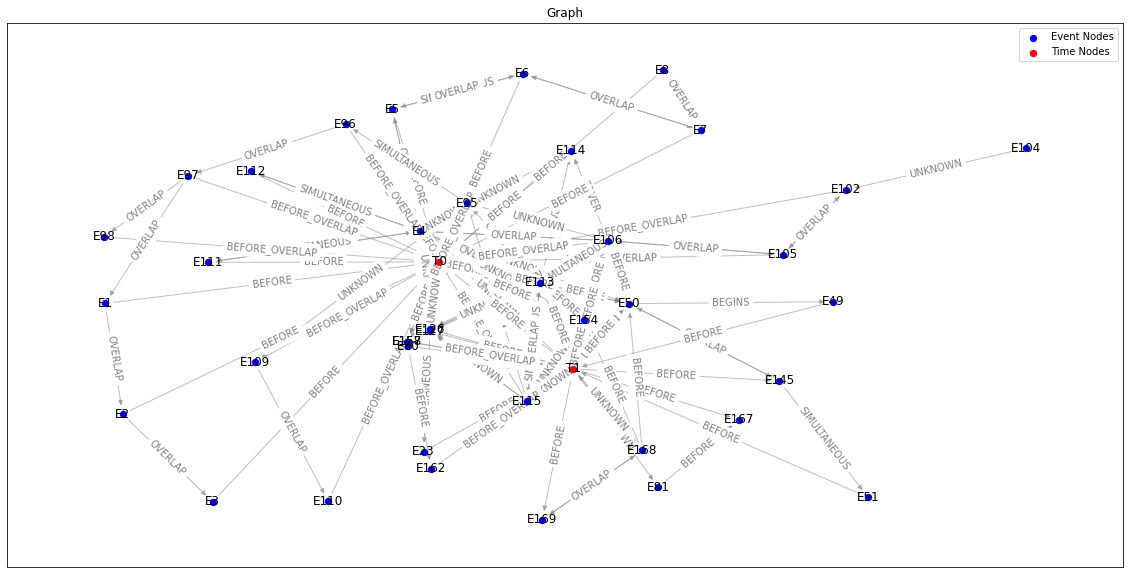

In [22]:
draw_graph(fil_subgraph, show_edge_labels=True)

In [23]:
fil_subgraph = get_node_subgraph(fil_subgraph, 'E4', excluded_edge_type=['UNKNOWN'])

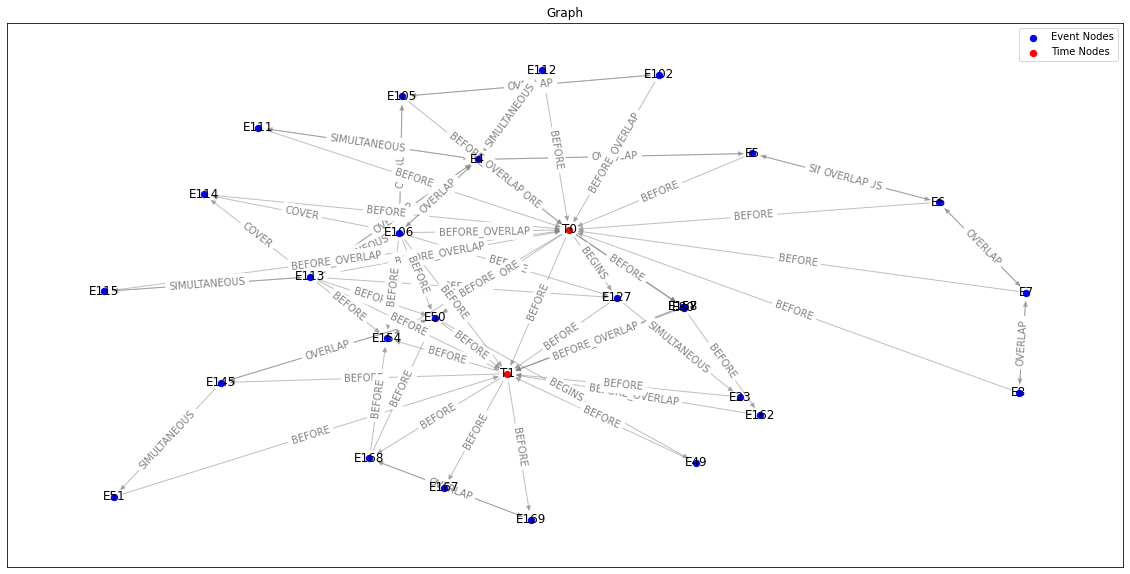

In [24]:
draw_graph(fil_subgraph, show_edge_labels=True)

In [25]:
print_long_paths_of_a_node(fil_subgraph, 'E4', abbr_path=False)

['Backward: (E102, PROBLEM, short of breath) -> [OVERLAP] -> (E105, PROBLEM, Her shortness of breath) -> [OVERLAP] -> (E106, PROBLEM, dyspnea) -> [SIMULTANEOUS] -> (E113, PROBLEM, lower extremity edema) -> [OVERLAP] -> (E4, PROBLEM, chest twinges)',
 'Forward: (E4, PROBLEM, chest twinges) -> [OVERLAP] -> (E5, PROBLEM, sweating) -> [OVERLAP] -> (E6, PROBLEM, nausea) -> [OVERLAP] -> (E7, PROBLEM, vomiting) -> [OVERLAP] -> (E8, PROBLEM, syncope) -> [BEFORE] -> (T0, DATE, 02/01/2002) -> [BEFORE] -> (E157, TEST, the above testing)',
 'Forward: (E4, PROBLEM, chest twinges) -> [OVERLAP] -> (E113, PROBLEM, lower extremity edema) -> [SIMULTANEOUS] -> (E106, PROBLEM, dyspnea) -> [OVERLAP] -> (E105, PROBLEM, Her shortness of breath) -> [OVERLAP] -> (E102, PROBLEM, short of breath)',
 'Forward: (E4, PROBLEM, chest twinges) -> [OVERLAP] -> (E5, PROBLEM, sweating) -> [OVERLAP] -> (E6, PROBLEM, nausea) -> [OVERLAP] -> (E7, PROBLEM, vomiting) -> [OVERLAP] -> (E8, PROBLEM, syncope) -> [BEFORE] -> (T0, 